# Caderno 6 - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos com doc2query

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/6_metricas_bm25_com_doc2query/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_doc2query.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_DOC2QUERY = f'{PASTA_DADOS}outputs/5_doc2query/'
NOME_ARQUIVO_DOC2QUERY = f'{PASTA_CADERNO_DOC2QUERY}doc2query.pickle'

# Fazemos o caminho inverso aqui:
with open(NOME_ARQUIVO_DOC2QUERY, 'rb') as f:
    queries_por_doc = pickle.load(f)

Insere a informação do doc2query no dataframe de documentos. Se o doc2query tiver gerado queries idênticas, desconsidera as duplicadas:

In [4]:
docs['DOC2QUERY'] = docs['KEY'].map(lambda key: " ".join(set(queries_por_doc[key])) )

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt
import re

# Função para remover tags HTML
def remove_html(html):
  return re.sub("<[^>]*>", "", html).strip()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar apenas o enunciado e excerto.
iidx = IndiceInvertido(lambda texto: tokenizador_pt(remove_html(texto)))

if REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY):
    # Se for indexar a primeira vez:
    # Demora cerca de XX minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['DOC2QUERY']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)

100%|████████████████████████████████████████████████████████████████████████████| 16045/16045 [31:50<00:00,  8.40it/s]


In [13]:
print(iidx.get_tamanho_medio_docs())

496.6854471798068


In [48]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [49]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [50]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.384000,0.328000,0.137600,0.155196,0.268060,0.562088,0.631667,0.640714,0.646485,0.397223,0.375083,0.513416
std,14.57738,0.282381,0.190638,0.050892,0.115963,0.166290,0.241502,0.386159,0.372520,0.362821,0.287662,0.228337,0.215974
min,1.00000,0.000000,0.000000,0.040000,0.000000,0.000000,0.133333,0.000000,0.000000,0.047619,0.000000,0.000000,0.069683
25%,13.25000,0.200000,0.200000,0.105000,0.071429,0.133333,0.395604,0.333333,0.333333,0.333333,0.170093,0.186419,0.322349
50%,25.50000,0.400000,0.300000,0.140000,0.142857,0.250000,0.545455,0.500000,0.500000,0.500000,0.359445,0.381714,0.559164
75%,37.75000,0.600000,0.500000,0.180000,0.230769,0.384615,0.778571,1.000000,1.000000,1.000000,0.617937,0.570334,0.704286
max,50.00000,1.000000,0.700000,0.220000,0.500000,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.844624


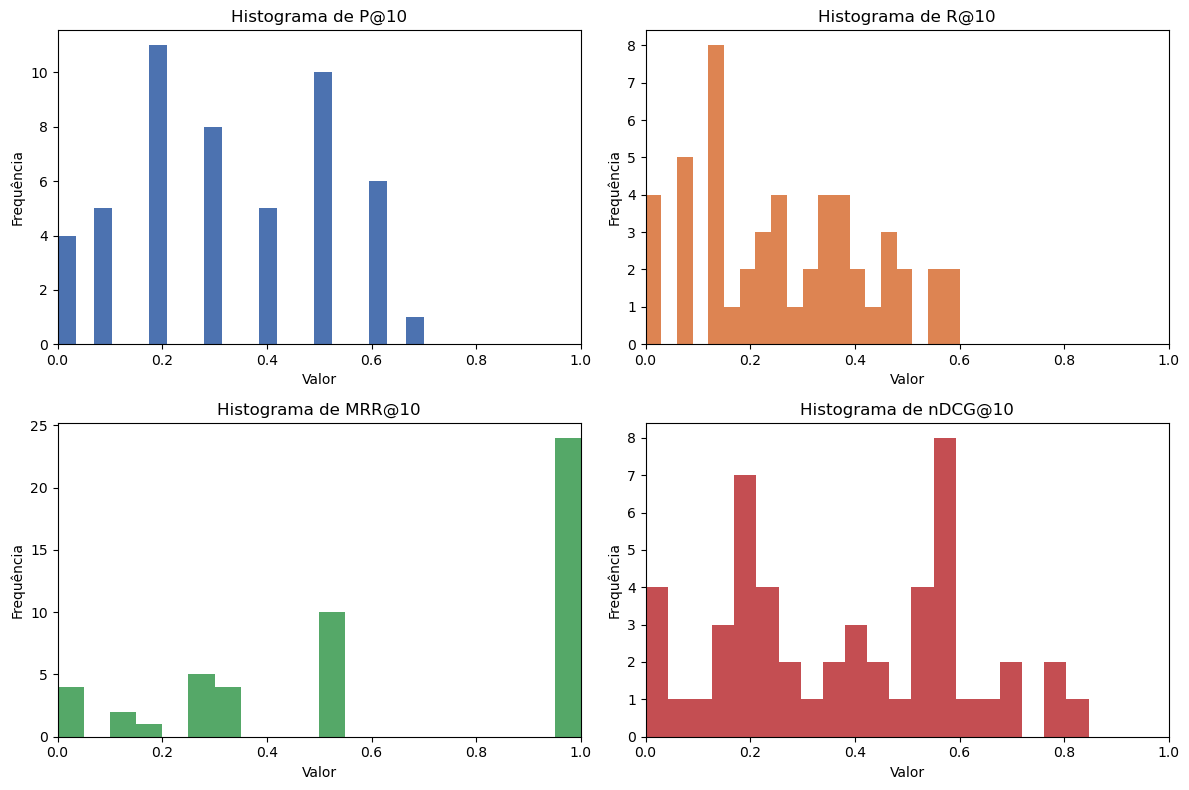

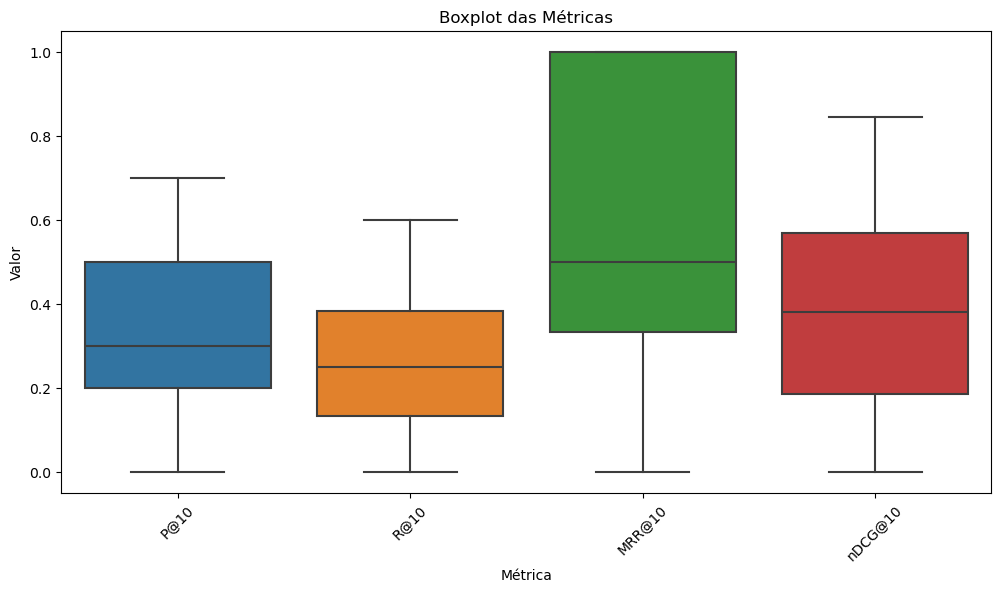

In [51]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.544000,0.396000,0.144000,0.228134,0.333435,0.599726,0.899000,0.903444,0.903444,0.621383,0.544876,0.647425
std,14.57738,0.274167,0.205992,0.049816,0.120330,0.188819,0.224666,0.265055,0.250167,0.250167,0.234069,0.191443,0.176905
min,51.00000,0.000000,0.100000,0.020000,0.000000,0.071429,0.083333,0.000000,0.111111,0.111111,0.000000,0.051685,0.127326
25%,63.25000,0.400000,0.200000,0.105000,0.145604,0.224359,0.461538,1.000000,1.000000,1.000000,0.508740,0.426671,0.582096
50%,75.50000,0.600000,0.400000,0.160000,0.230769,0.320513,0.607692,1.000000,1.000000,1.000000,0.656886,0.586693,0.652317
75%,87.75000,0.800000,0.500000,0.180000,0.307692,0.425595,0.764423,1.000000,1.000000,1.000000,0.755317,0.682128,0.762523
max,100.00000,1.000000,0.800000,0.200000,0.500000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,0.860382,0.963408


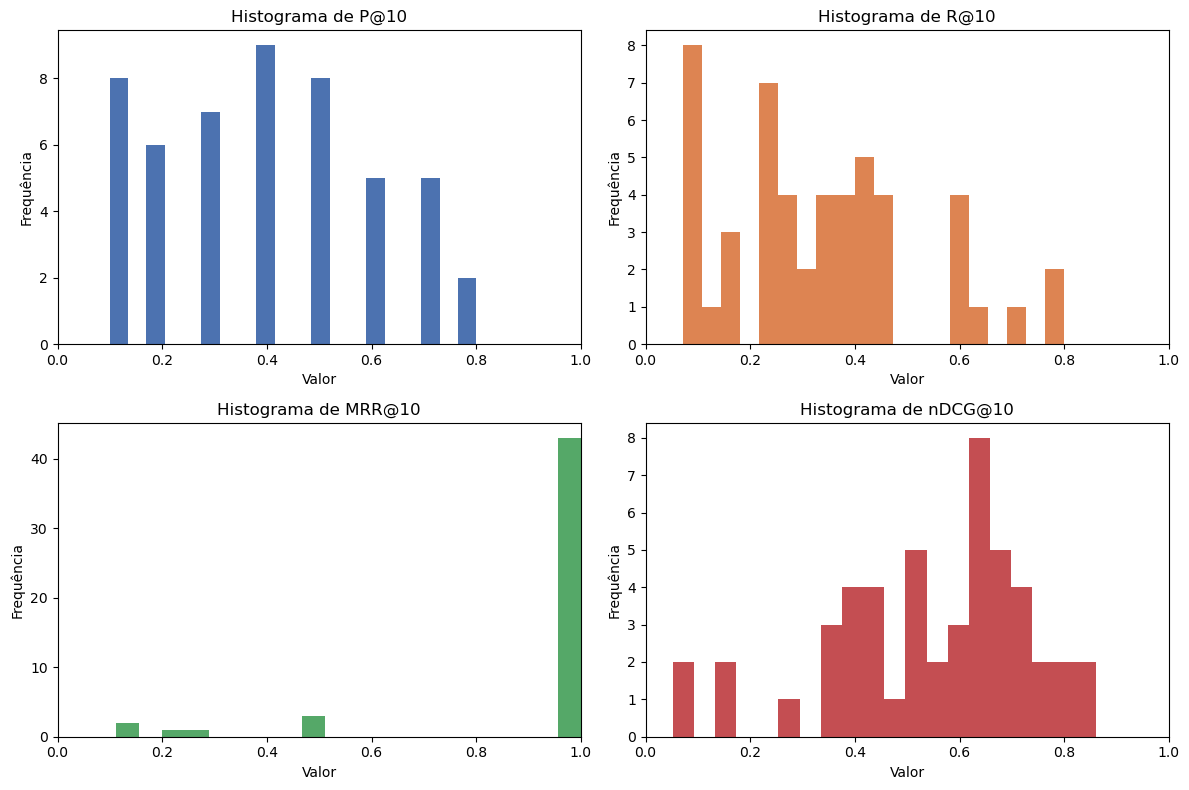

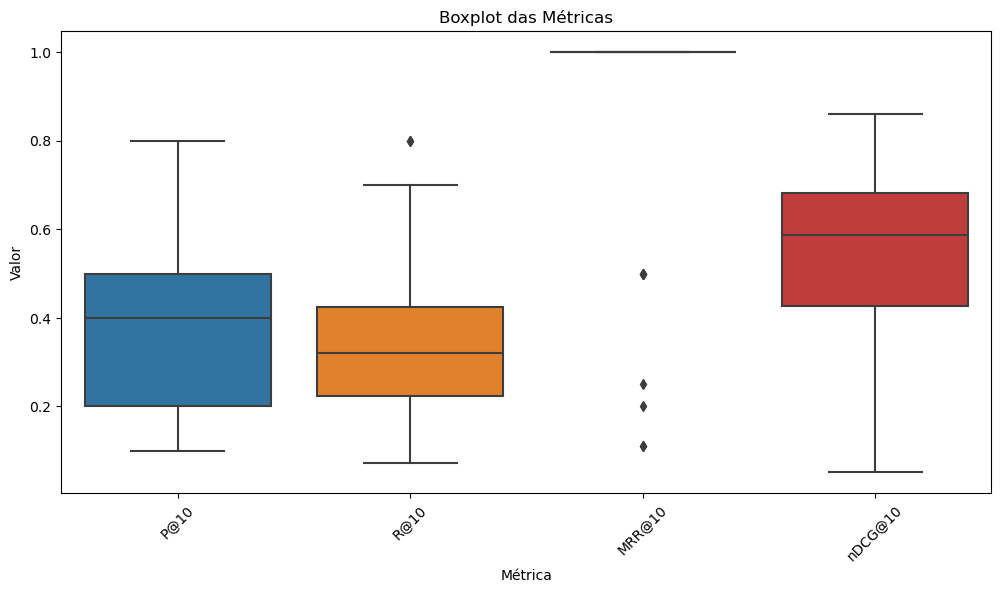

In [11]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.532000,0.400000,0.139200,0.239059,0.355019,0.612787,0.95400,0.956222,0.956222,0.627193,0.551942,0.656439
std,14.57738,0.247798,0.196915,0.052366,0.119143,0.173357,0.229170,0.19082,0.179813,0.179813,0.204666,0.176814,0.163838
min,101.00000,0.000000,0.100000,0.020000,0.000000,0.066667,0.100000,0.00000,0.111111,0.111111,0.000000,0.070969,0.273531
25%,113.25000,0.400000,0.225000,0.120000,0.166667,0.230769,0.538462,1.00000,1.000000,1.000000,0.507790,0.462463,0.523164
50%,125.50000,0.600000,0.400000,0.140000,0.240385,0.333333,0.615385,1.00000,1.000000,1.000000,0.607863,0.571441,0.686982
75%,137.75000,0.750000,0.500000,0.180000,0.325000,0.459790,0.750000,1.00000,1.000000,1.000000,0.777695,0.692711,0.783921
max,150.00000,1.000000,0.800000,0.220000,0.500000,0.727273,1.000000,1.00000,1.000000,1.000000,1.000000,0.884592,0.949787


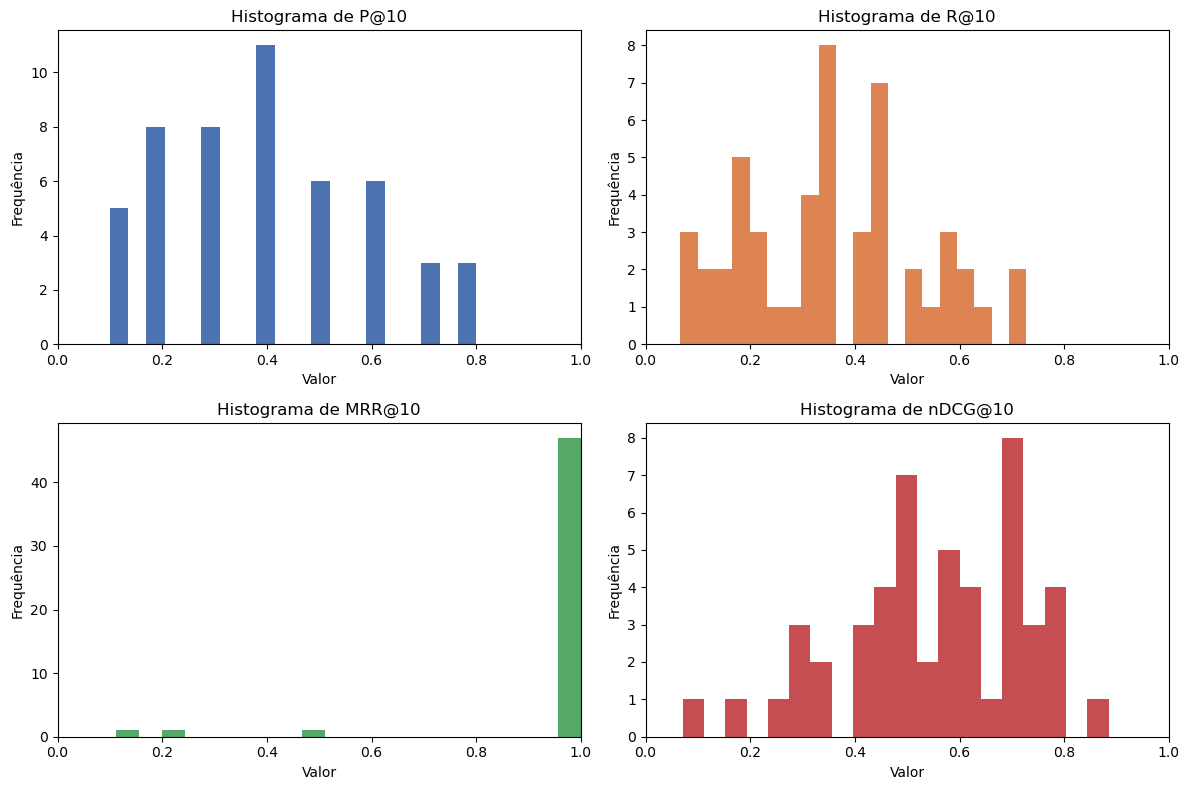

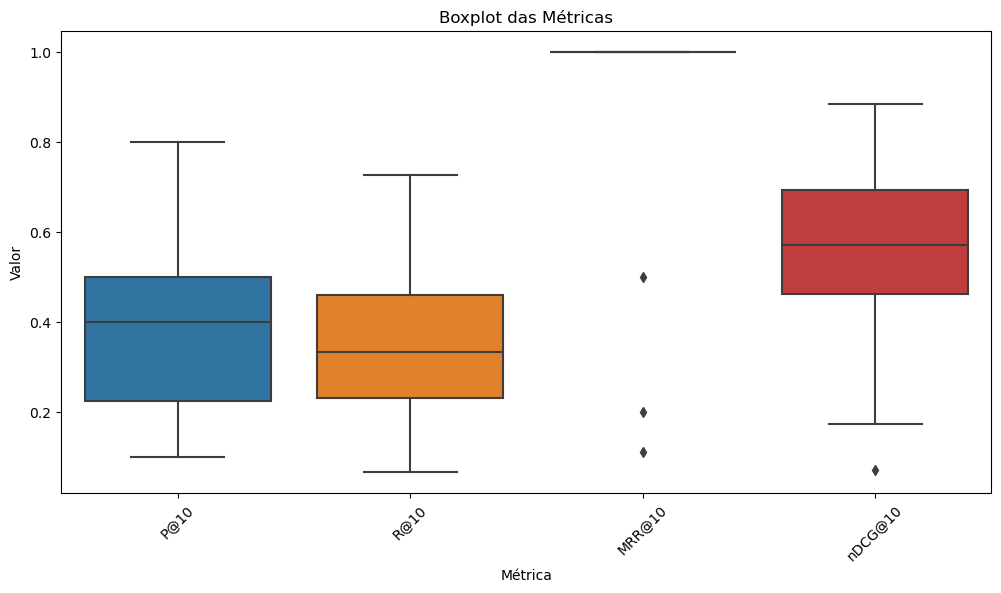

In [12]:
# Resultados para o primeiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])

## Testes para comparar com os resultados com uma busca do BM25 implementado no LangChain

https://api.python.langchain.com/en/latest/retrievers/langchain_community.retrievers.bm25.BM25Retriever.html#langchain_community.retrievers.bm25.BM25Retriever

https://python.langchain.com/v0.1/docs/integrations/retrievers/bm25/

In [20]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

# Converte para documentos
docs_langchain = []
for i, row in docs.iterrows():
    docs_langchain.append(Document(page_content=row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['DOC2QUERY'], metadata={"KEY": row['KEY']}))

In [23]:
%%time
# Demora cerca de 35 minutos para indexar
retriever = BM25Retriever.from_documents(docs_langchain, preprocess_func=lambda texto: tokenizador_pt(remove_html(texto)))

CPU times: total: 22min 52s
Wall time: 35min 52s


In [35]:
# Altera para mostrar 50 resultados e testa pra ver se ele está aplicando a função de pré-processamento correta na query:
retriever.k = 50
retriever.preprocess_func('<a>técnica e preço')

['tecn', 'prec']

In [41]:
lang_col_resultado_query_key=[]
lang_col_resultado_doc_key=[]
lang_col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = retriever.invoke(query_text)
  
    primeiros_50_docs = [resultado.metadata['KEY'] for resultado in resultados]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    lang_col_resultado_query_key.extend(queries_keys)
    lang_col_resultado_doc_key.extend(primeiros_50_docs)
    lang_col_resultado_rank.extend(ranking)
    
df_resultados_langchain = pd.DataFrame({
    "QUERY_KEY": lang_col_resultado_query_key,
    "DOC_KEY": lang_col_resultado_doc_key,
    "RANK": lang_col_resultado_rank,
})

In [42]:
df_metricas_langchain = metricas(df_resultados_langchain, qrels, aproximacao_trec_eval=True)

O resultado está próximo ao implementado com a implementação própria. Difere ligeiramente, mas é devido à própria implementação do BM25.

O BM25Retriever do LangChain Community é um wrapper para o https://github.com/dorianbrown/rank_bm25/blob/master/rank_bm25.py . Nesse, a implementação do IDF é ligeiramente diferente: ele calcula log[(N - n + 0.5)/(n + 0.5)]. Na minha implementação, calculo log[(N - n + 0.5)/(n + 0.5) + bias], com bias = 1.

O bias = +1 que uso veio do modelo da Wikipedia e é uma forma de se evitar valores negativos para o IDF. Na implementação do BM25 Okapi, isso é resolvido de forma diferente. Após o cálculo, ele troca os idfs negativos por eps multiplicado pela média dos idfs dos termos do corpus.

A implementação padrão do BM25 Okapi usa k1=1.5, b=0.75, epsilon=0.25.

Rodar a implementação própria com k1=1.5, b=0.75 traz resultados muito próximos ao BM25Retriever.

,QUERY_KEY,P@5,P@10,P@50,R@5,R@10,R@50,MRR@5,MRR@10,MRR@50,nDCG@5,nDCG@10,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.388000,0.344000,0.137600,0.156252,0.280529,0.561993,0.630667,0.640667,0.645152,0.397613,0.383054,0.511890
std,14.57738,0.275266,0.184236,0.050247,0.113311,0.161079,0.237314,0.392682,0.378057,0.370665,0.288272,0.229827,0.219318
min,1.00000,0.000000,0.000000,0.040000,0.000000,0.000000,0.133333,0.000000,0.000000,0.066667,0.000000,0.000000,0.111933
25%,13.25000,0.200000,0.200000,0.100000,0.071429,0.145604,0.384615,0.270833,0.270833,0.270833,0.169580,0.186411,0.320265
50%,25.50000,0.400000,0.300000,0.140000,0.142857,0.286364,0.545455,0.750000,0.750000,0.750000,0.386110,0.387672,0.565479
75%,37.75000,0.600000,0.500000,0.180000,0.223077,0.396154,0.744318,1.000000,1.000000,1.000000,0.614226,0.572608,0.703948
max,50.00000,1.000000,0.700000,0.220000,0.500000,0.600000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.842570


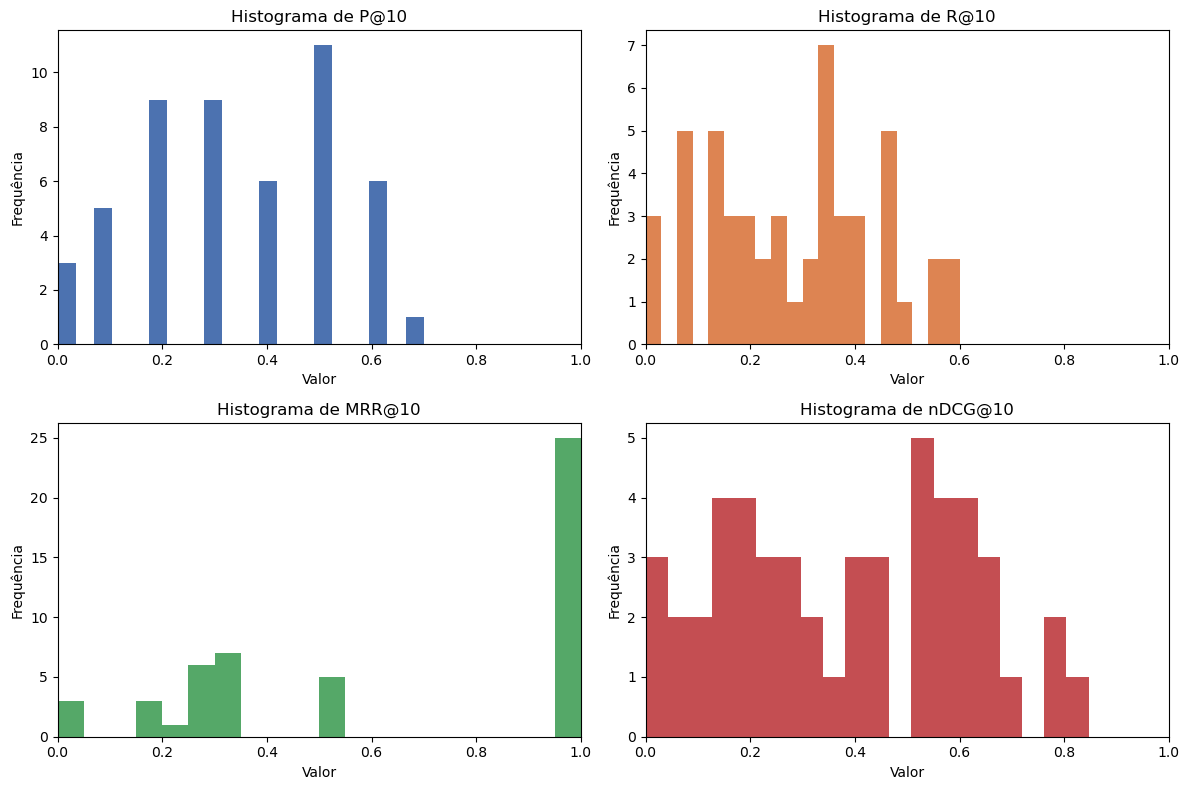

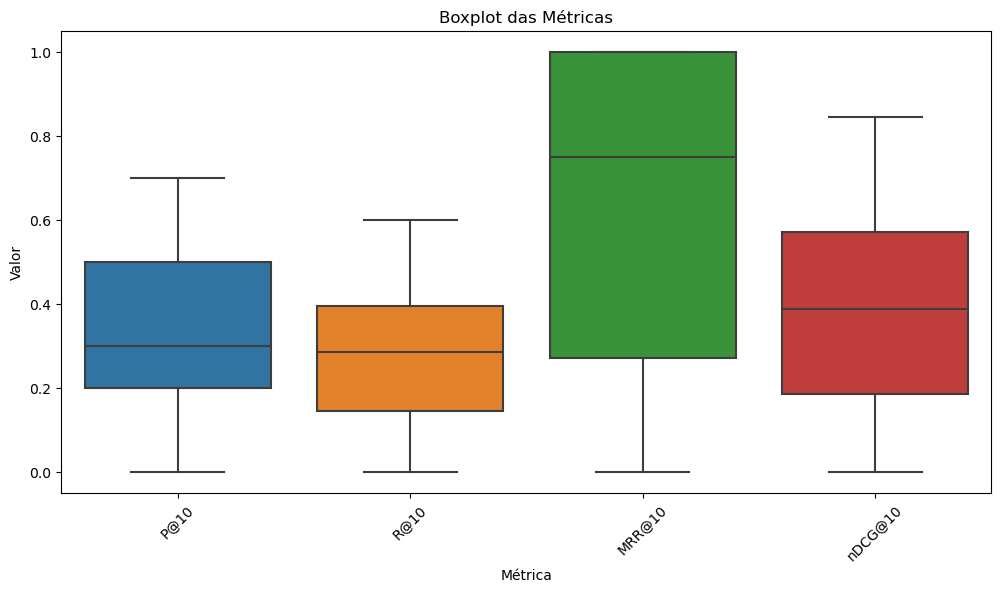

In [43]:
# Resultados para o primeiro grupo de queries:
display(df_metricas_langchain[0:50].describe())
histograma_metricas(df_metricas_langchain[0:50])
boxplot_metricas(df_metricas_langchain[0:50])